## Capstone Project: City recommender (for visiting or living)
*Auther: Xinyue Luo*

### The business problem
Looking for a dream city to start a new life or a perfect place to spend your vacation is a big commitment which begins with lots of online search for reviews, or even in-person visits. This learning process could be tiring and time-consuming. Can we make this process a little less stressful by generating recommendations using local information available online, based on customized user preferences of city features?

- **Primary objective:** 
In this project, I will build a clustering tool which can be used to **provide recommendations of cities** that one would like to live in or visit, based on **nearby local attractions** (restaurants, parks, etc.) and the **user's preferences** (e.g. a known favorate city/neighborhood or preference for creative attractions like museums).
- **Secondary objective:**
For top cities on the recommendation list generated from previous step, I will perform clustering (either with k-means or DBSCAN) to identify centroids/hubs of attractions as well as the most popular attraction types. With these new insights, a further narrowed-down recommendation list of locations within each city will be generated. 

### Data overview
#### Part 1: Data collection
1. Largest ~20 cities by population on the US east coast (list obtained from Wikipedia page https://en.wikipedia.org/wiki/Eastern_United_States) will be involved in clustering; area information will also be obtained from each city's main page on Wikipedia to determine the search radius for venue search.
2. Information of nearby venues **(latitute, longitute, category)** will be obtained from **FOURSQUARE** for each city involved.

#### Part 2: Data understanding and modeling
3. A **normalized frequency count of each venue category** for each city will be used as independent variables when performing clustering of all cities involved in this study.
4. Recommended cities will be returned as final results, once a user inputs a known favorate city, or preferences for ideal city (represented as venue categories and score/weight - higher score/weight is converted to preference for higher frequency of such venture category in the city).
5. For each recommended city on the list from step 4, local venues will be clustered (using k-means or DBSCAN). The venue number and popular venue categories of each cluster will be used to match with user's preferences to further narrow-down recommended regions in each city.

***
- *More features could be added to **Step 3** as independent variables to improve clustering accuracy. For example, the distrubution pattern (e.g. number and coordinates of centroids/hubs, number of members in a cluster) of local restaurants/shops could indicate whether/how a shopping/entertainment hub exists, which could result in very different clustering result comparing to when not considered.*

***
### Part 1: Data collection
### 1. Get a list of largest cities on the east coast of US from Wikipedia page

In [1]:
# import libraries for webscraping
from bs4 import BeautifulSoup
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# import additional libraries for venue data acquisition
from geopy.geocoders import Nominatim
import geocoder

# import modeling and plotting libraries
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import pickle

In [2]:
# get raw list of top cites from the Wikipedia page "Eastern United States"
webpage = requests.get("https://en.wikipedia.org/wiki/Eastern_United_States").text
soup = BeautifulSoup(webpage, 'lxml')
cities_gallery = soup.find('ul', class_='gallery mw-gallery-traditional')
cities = cities_gallery.find_all('div', class_='gallerytext')
cities[0:2]

[<div class="gallerytext">
 <p><a href="/wiki/New_York_City" title="New York City">New York City</a><br/>population: 8,622,698
 </p>
 </div>, <div class="gallerytext">
 <p><a href="/wiki/Chicago" title="Chicago">Chicago</a><br/>population: 2,695,598
 </p>
 </div>]

In [3]:
# define a function to scrape information from city's main Wikipedia page
# 2 information obtained: [state the city is located in, area of city]
def get_info(url_extention):

    city_page = requests.get("https://en.wikipedia.org" + url_extention).text
    soup = BeautifulSoup(city_page, 'lxml')
    geoinfo = soup.find('table', class_='infobox geography vcard')
    trs = geoinfo.find_all('tr')

    result = ['', '']
    i = 0
    for tr in trs:
        i += 1
        try:
            header = tr.find('th').text
            if header[-1] == ']':
                header = header[:header.find('[')]
        except:
            continue
            
        if header == 'State':
            result[0] = tr.find('td').text
        if header == 'Area':
            result[1] = trs[i].find('td').text
        if result[0] and result[1]:
            break
    return result

In [5]:
# extract city name and population information from raw html and convert into pandas dataframe object
city_list = []
for city in cities:
    a = city.find('a', href=True)
    info = get_info(a['href'])
    
    # some entries contain an extra '\n' in the end; remove 
    if len(info[0])>0 and info[0][-1] == '\n':
        info[0] = info[0][:-1]
        
    temp = [a.text, info[0], info[1], city.find('p').text.split(': ', 1)[-1][:-1]]
    city_list.append(temp)
df_city = pd.DataFrame(city_list, columns=['City', 'State', 'Area', 'Population'])
print('On the list are', df_city.shape[0], 'largest cities on the east coast(by population).')
df_city.head()

On the list are 24 largest cities on the east coast(by population).


,City,State,Area,Population
0,New York City,New York,"468.484 sq mi (1,213.37 km2)","8,622,698"
1,Chicago,Illinois,234.14 sq mi (606 km2),"2,695,598"
2,Philadelphia,Pennsylvania,142.71 sq mi (369.62 km2),"1,567,827"
3,Jacksonville,Florida,"874.64 sq mi (2,265.30 km2)","821,784"
4,Indianapolis,Indiana,368.02 sq mi (953.18 km2),"820,445"


In [6]:
# cleanup the 'City' column so that there's no state information, except for 'Washington, D.C.'
df_city['City'] = df_city['City'].str.split(',').str[0]
df_city.loc[8, 'City'] = 'Washington, D.C.'

In [7]:
# cleanup the 'Area' column so that area is only represented in km2
km = df_city['Area'].str.find('km2')
p_left = df_city['Area'].str.find('(')

df_city.loc[km>p_left, 'Area'] = df_city.loc[km>p_left, 'Area'].apply(lambda x: x[(x.find('(')+1):-5])
df_city.loc[km<p_left, 'Area'] = df_city.loc[km<p_left, 'Area'].apply(lambda x: x[:(x.find('km2')-1)])

# convert string to float and change column name to specify unit
df_city['Area'] = df_city['Area'].str.replace(',','').astype(float)
df_city.rename(columns={"Area":"Area (km2)"}, inplace=True)

# add raius column: assume each city is a circle, thus radius=sqrt(area/pi), convert km to m
df_city['Radius (m)'] = 1000*np.sqrt(df_city['Area (km2)']/np.pi)
df_city.head()

,City,State,Area (km2),Population,Radius (m)
0,New York City,New York,1213.37,"8,622,698",19652.675813
1,Chicago,Illinois,606.00,"2,695,598",13888.692920
2,Philadelphia,Pennsylvania,369.62,"1,567,827",10846.829036
3,Jacksonville,Florida,2265.30,"821,784",26852.697912
4,Indianapolis,Indiana,953.18,"820,445",17418.571047


***
### 2. Get nearby venues (latitute, longitute, category) from FOURSQUARE API for each city

In [21]:
# @hidden_cell
CLIENT_ID = 'LI3A1RJPXEDEZPARE1JT2CWUWFFAYKXXHB3LENOA0T1KF5HJ' # your Foursquare ID
CLIENT_SECRET = 'EEK4FRAQRPKXCYLJRQHGRYOA2YFH5WZNTWEQWJDT34YICH01' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Foursquare credentails set!')

Foursquare credentails set!


In [8]:
# define a function to get geographic information [latitude, longitude] for each city
def get_geo(address):
    geolocator = Nominatim(user_agent="EastCoast_explorer")
    loc_custom = geolocator.geocode(address)
    return [loc_custom.latitude, loc_custom.longitude]

In [10]:
# loop through each row in the city dataframe and append geographical information
df_city['Latitude'] = np.nan
df_city['Longitude'] = np.nan

for index, row in df_city.iterrows():
    address = row['City'] + ', ' + row['State']
    temp_geo = get_geo(address)
    df_city.at[index, 'Latitude'] = temp_geo[0]
    df_city.at[index, 'Longitude'] = temp_geo[1]
    
df_city.to_csv('dream_city_candidates.csv')
df_city

,City,State,Area (km2),Population,Radius (m),Latitude,Longitude
0,New York City,New York,1213.37,"8,622,698",19652.675813,40.730862,-73.987156
1,Chicago,Illinois,606.00,"2,695,598",13888.692920,41.875562,-87.624421
2,Philadelphia,Pennsylvania,369.62,"1,567,827",10846.829036,39.952415,-75.163575
3,Jacksonville,Florida,2265.30,"821,784",26852.697912,30.332184,-81.655651
4,Indianapolis,Indiana,953.18,"820,445",17418.571047,39.768333,-86.158350
5,Columbus,Ohio,577.85,"787,033",13562.277380,39.962260,-83.000707
6,Charlotte,North Carolina,771.00,"731,424",15665.788274,35.227087,-80.843127
7,Detroit,Michigan,370.08,"713,777",10853.576493,42.331551,-83.046640
8,"Washington, D.C.",,177.00,"703,608",7506.054213,38.895009,-77.036563
9,Boston,Massachusetts,232.14,"667,137",8596.072183,42.360253,-71.058291


In [9]:
# defind a function to get up to 200 venues nearby each city's geographic coordinates
def getNearbyVenues(cities, latitudes, longitudes, radius, limi):
    
    venues_list=[]
    for city, lat, lng, rad in zip(cities, latitudes, longitudes, radius):

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            limi)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return relevant information for each nearby venue
        venues_list.append([(
            city, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# get all venues for cities on list
EastCoastCities_venues = getNearbyVenues(cities=df_city['City'], 
                                         latitudes=df_city['Latitude'], 
                                         longitudes=df_city['Longitude'], 
                                         radius=df_city['Radius (m)'], limi=200)
EastCoastCities_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York City,40.730862,-73.987156,Sake Bar Decibel,40.729418,-73.987769,Sake Bar
1,New York City,40.730862,-73.987156,Peridance Capezio Center,40.732987,-73.988522,Dance Studio
2,New York City,40.730862,-73.987156,Trader Joe's Wine Shop,40.733750,-73.988128,Wine Shop
3,New York City,40.730862,-73.987156,Strand Bookstore,40.733140,-73.990912,Bookstore
4,New York City,40.730862,-73.987156,The Public Theater,40.729169,-73.992070,Theater


In [16]:
# take a look at the venue data and save to .csv
print(EastCoastCities_venues.shape)
EastCoastCities_venues.to_csv('dream_city_venues.csv')

(2400, 7)


***
### Part 2: Data understanding and modeling
### 3. Get normalized frequencies of each venue type in each city as features for k-means clustering

In [10]:
df_venue = pd.read_csv('dream_city_venues.csv')

# one hot encoding
venue_onehot = pd.get_dummies(df_venue[['Venue Category']], prefix="", prefix_sep="")

# add city column as first column
venue_onehot.insert(loc=0, column='City', value=df_venue['City'])
venue_onehot.head()

,City,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Football Field,College Quad,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Romanian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skydiving Drop Zone,Smoke Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Steakhouse,Street Food Gathering,Strip Club,Supermarket,Surf Spot,Sushi Restaurant,Synagogue,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Track,Trail,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,New York City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,New York City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [26]:
# group to get frquencies of each venue type
venue_grouped = venue_onehot.groupby('City').mean().reset_index()
venue_grouped.to_csv("dream_city_venue_grouped.csv")
print(venue_grouped.shape)
venue_grouped.head(10)

(24, 245)


,City,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Football Field,College Quad,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Romanian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skydiving Drop Zone,Smoke Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Steakhouse,Street Food Gathering,Strip Club,Supermarket,Surf Spot,Sushi Restaurant,Synagogue,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Track,Trail,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Atlanta,0.00,0.00,0.05,0.00,0.01,0.01,0.00,0.0,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.02,0.00,0.01,0.00,0.00,0.0,0.02,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.0,0.01,0.03,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.01,0.01,0.00,0.0,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.01,0.00,0.0,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.0,0.03,0.0,0.00,0.00,0.0,0.00,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.01,0.00,0.00,0.0,0.00,0.0,0.01,0.02,0.0,0.00,0.00,0.0,0.0,0.00,0.01,0.02,0.0,0.00,0.0,0.00,0.00,0.0

In [11]:
# get total number of venue types present in each city
type_count = []
for i in range(venue_grouped.shape[0]):
    count_temp = venue_grouped.iloc[i,1:].value_counts()
    count_present = venue_grouped.shape[1] - 1 - count_temp.at[0.0]
    type_count.append([venue_grouped.iloc[i,0], count_present])
    
type_count.sort(key=(lambda x: x[1]), reverse=True)
df_totaltype = pd.DataFrame(type_count, columns=['City', 'VenueTypeCount'])
df_totaltype.head()

,City,VenueTypeCount
0,Baltimore,65
1,Philadelphia,64
2,Chicago,63
3,Indianapolis,62
4,Memphis,62


(40, 70)

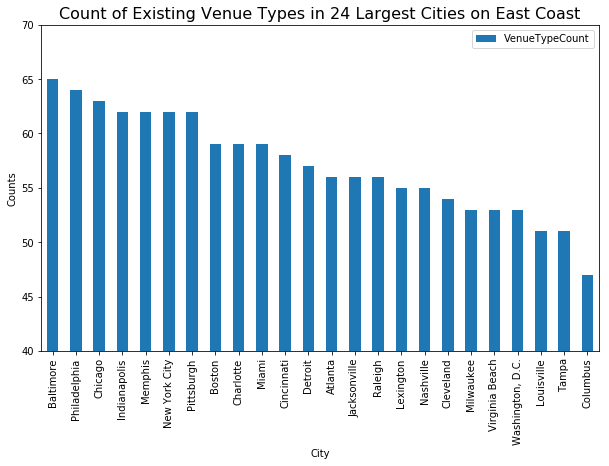

In [15]:
# plot the venue type counts for all 24 cities
df_totaltype.plot(kind='bar', x='City', y='VenueTypeCount', figsize=(10, 6))
plt.title('Count of Existing Venue Types in 24 Largest Cities on East Coast', fontsize=16)
plt.ylabel('Counts')
ax = plt.gca()
ax.set_ylim([40,70])

#### Exploritory space: explore the impact of k on k-means clustering

- With all cities

In [12]:
# define a function to fit kmeans and plot k vs distortion
# to use the elbow method to determine optimal k value
def run_kmeans(X, title_ext, k_upper=10):
    distortions = []
    for kclusters in range(1, k_upper):
        kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        #distortions.append(kmeans.inertia_)
    
    # print the optimal k
    print('The optimal k value for ' + title_ext + ' is', optimal_k(k_upper, distortions))

    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(4)

    plt.plot(range(1, k_upper), distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k (' + title_ext + ')')
    plt.show()
    return optimal_k(k_upper, distortions)

In [13]:
# define a function to return the optimal k by comparing the slope between 2 consecutive k values
def optimal_k(k_upper, distortions):
    slope_diff = []
    
    for x in range(1, k_upper-2):
        slope_diff.append((distortions[x-1] - distortions[x]) - (distortions[x] - distortions[x+1]))
    
    return (2 + slope_diff.index(max(slope_diff)))

The optimal k value for All Cities is 8


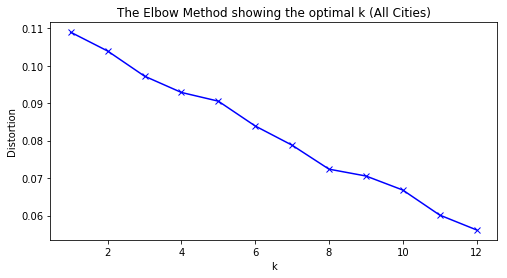

In [14]:
# k-mean clustering for all cities included
choice_k = run_kmeans(venue_grouped.drop('City', 1), 'All Cities', k_upper=13)

- View top 10 features in each city

In [15]:
# defind a function to get top n popular venue types 
def get_popular_venues(city, top_n):
    venue_sorted = city.iloc[1:].sort_values(ascending=False)    
    return venue_sorted.index.values[0:top_n]

In [24]:
# create columns for top n categories
top_n = 10
columns = ['City']
for i in np.arange(top_n):
    columns.append('Top {}'.format(i+1))

# create dataframe of top venue catergories in select cities
df_topvenue = pd.DataFrame(columns=columns)
df_topvenue['City'] = venue_grouped['City']

for i, city in df_topvenue.iterrows():
    df_topvenue.iloc[i, 1:] = get_popular_venues(venue_grouped.iloc[i,:], top_n)

df_topvenue

,City,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
0,Atlanta,Trail,American Restaurant,Park,Southern / Soul Food Restaurant,Mexican Restaurant,Restaurant,Brewery,Mediterranean Restaurant,Donut Shop,Seafood Restaurant
1,Baltimore,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Lounge,Bakery,Bar,Hotel,Park,Middle Eastern Restaurant
2,Boston,Park,Bakery,Hotel,Italian Restaurant,Seafood Restaurant,Coffee Shop,Gym,Salad Place,Pizza Place,Historic Site
3,Charlotte,Brewery,BBQ Joint,American Restaurant,Italian Restaurant,Deli / Bodega,Bakery,Pizza Place,Steakhouse,Park,Grocery Store
4,Chicago,Hotel,Park,New American Restaurant,Theater,Italian Restaurant,Seafood Restaurant,Sandwich Place,Japanese Restaurant,Cocktail Bar,Boat or Ferry
5,Cincinnati,Bar,Park,Italian Restaurant,American Restaurant,Coffee Shop,Restaurant,Cocktail Bar,Gastropub,Pizza Place,Theater
6,Cleveland,Coffee Shop,American Restaurant,Gastropub,Brewery,Hotel,Italian Restaurant,Steakhouse,Theater,New American Restaurant,Park
7,Columbus,American Restaurant,Park,Café,Coffee Shop,Bar,Pizza Place,Taco Place,Gastropub,Hotel,Restaurant
8,Detroit,Park,American Restaurant,Coffee Shop,Bar,Brewery,Burger Joint,Restaurant,Plaza,Hotel,Concert Hall
9,Indianapolis,Bar,Pizza Place,Brewery,Mexican Restaurant,Hotel,Trail,Sandwich Place,History Museum,Café,Steakhouse


In [25]:
# count the frequencies of venue types on the top 10 list of all cities
df_topvenue.stack().value_counts()

American Restaurant                19
Park                               19
Coffee Shop                        16
Hotel                              16
Pizza Place                        12
Italian Restaurant                 12
Bar                                12
Brewery                            10
Restaurant                          8
Seafood Restaurant                  7
Burger Joint                        6
Bakery                              6
Theater                             5
Café                                5
Gastropub                           5
Sandwich Place                      5
Grocery Store                       4
Mexican Restaurant                  4
Cocktail Bar                        4
Steakhouse                          4
New American Restaurant             3
BBQ Joint                           3
Breakfast Spot                      3
History Museum                      2
Lounge                              2
Southern / Soul Food Restaurant     2
Music Venue 

- Visualize the 8 clusters on map

In [21]:
# run kmeans at the optimal k
kclusters = choice_k
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped.drop('City', 1))

# append cluster label to new dataframe
df_labeled = venue_grouped.drop(venue_grouped.columns[range(1,venue_grouped.shape[1])], axis=1)
df_labeled.insert(loc=0, column='Cluster Labels', value=kmeans.labels_)

# merge to create new dataframe with location info and labels
df_city = pd.read_csv('dream_city_candidates.csv')
df_merged = pd.merge(df_labeled, df_city[['City', 'State', 'Latitude', 'Longitude']], on='City')

# save model and fit city list
df_merged.to_csv("dream_city_labeled.csv")
pickle.dump(kmeans, open('kmeans_eastcoast.sav', 'wb'))
print(df_merged.shape)
df_merged.head()

(24, 5)


,Cluster Labels,City,State,Latitude,Longitude
0,3,Atlanta,Georgia,33.749099,-84.390185
1,4,Baltimore,Maryland,39.290882,-76.610759
2,2,Boston,Massachusetts,42.360253,-71.058291
3,4,Charlotte,North Carolina,35.227087,-80.843127
4,2,Chicago,Illinois,41.875562,-87.624421


In [16]:
# define a function to plot map and add markers
def plot_map(map_clusters, kclusters, d_lat, d_lon, d_target, d_label):

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, target, label in zip(d_lat, d_lon, d_target, d_label):
        tag = folium.Popup(target + ' Cluster ' + str(label))
        folium.CircleMarker([lat, lon],
                            radius=5,
                            popup=tag,
                            color=rainbow[label-1]).add_to(map_clusters)

    return map_clusters

In [29]:
# center around Washington D.C.
w_ind = df_merged.index[df_merged['City']=='Washington, D.C.']
w_lat = df_merged.at[w_ind[0], 'Latitude']
w_lon = df_merged.at[w_ind[0], 'Longitude']

map_clusters = folium.Map(location=[w_lat, w_lon], zoom_start=5)
map_clusters = plot_map(map_clusters, choice_k, df_merged['Latitude'], df_merged['Longitude'], df_merged['City'], df_merged['Cluster Labels'])

map_clusters

***
### 4. Make predictions on best city to visit/live using trained cluster info

In [17]:
# define a function to get feature set for custom city
def get_custom_features_by_city(city, state):
    
    # get venues
    custom_geo = get_geo(city + ', ' + state)
    
    df_city = pd.read_csv('dream_city_candidates.csv', index_col=0)
    uniform_radius = df_city.describe().at['mean', 'Radius (m)']
    
    costom_venues = getNearbyVenues(cities=[city], 
                                    latitudes=[custom_geo[0]], 
                                    longitudes=[custom_geo[1]], 
                                    radius=[uniform_radius], limi=200)
    # onehot encode
    custom_onehot = pd.get_dummies(costom_venues[['Venue Category']], prefix="", prefix_sep="")
    custom_onehot.insert(loc=0, column='City', value=city)
    # get normalized features
    return custom_onehot.groupby('City').mean().reset_index()

In [18]:
# define a function to predict label
def get_custom_label(features, group_column):
    # load fit data 
    venue_grouped = pd.read_csv("dream_city_venue_grouped.csv", index_col=0)
    kmeans = pickle.load(open('kmeans_eastcoast.sav', 'rb'))
    
    # modify custom features according to trained features
    # drop features don't exist in trained data
    features.drop(features.columns[features.columns.isin(venue_grouped.columns)==False], 1, inplace=True)
    
    # merge by concat into trained data, fill nan with 0.00 and resort columns by alphabet
    temp = pd.concat([features, venue_grouped], ignore_index=True, sort=False)
    temp = temp.fillna(0.00)
    temp = temp.reindex(sorted(temp.columns), axis=1)
    temp.drop(temp.index[range(1,temp.shape[0])], axis=0, inplace=True)
    
    # get label
    custom_label = kmeans.predict(temp.drop(group_column, 1))
    return custom_label[0]

In [19]:
# define a function to print prediciton and return a list of top cities on east coast as recommendation
def get_recommendation(city, state, group_column):
    custom_label = get_custom_label(get_custom_features_by_city(city, state), group_column)
    
    df_labeled = pd.read_csv("dream_city_labeled.csv")
    print('Cluster Label for ' + city + ', ' + state + ' is ', str(custom_label))
    print('A list of cities on the east coast you may like: ', 
          list(df_labeled[df_labeled['Cluster Labels']==custom_label]['City']), 
          '. Corresponding states: ', 
          list(df_labeled[df_labeled['Cluster Labels']==custom_label]['State']))
    return [custom_label, 
            list(df_labeled[df_labeled['Cluster Labels']==custom_label]['City']), 
            list(df_labeled[df_labeled['Cluster Labels']==custom_label]['State'])]

In [22]:
city = input('Welcome to city recommender! Type your favorate city here:')
state = input('Type the state for the above city here:')
recommendation_list = get_recommendation(city, state, 'City')

Welcome to city recommender! Type your favorate city here:fremont
Type the state for the above city here:ca
Cluster Label for fremont, ca is  2
A list of cities on the east coast you may like:  ['Boston', 'Chicago', 'New York City'] . Corresponding states:  ['Massachusetts', 'Illinois', 'New York']


***
### 5. Cluster local venues based on geographic location and recommend a local cluster within a recommended city

In [34]:
# define a function to load venue info for a city of interest
def get_local_cluster(city, state):
    df_local = pd.read_csv('dream_city_venues.csv', index_col=0)
    df_local = df_local[df_local['City']==city]
    
    choice_k = run_kmeans(df_local[['Venue Latitude', 'Venue Longitude']], 'All Venues', k_upper=20)
    
    kmeans_venue = KMeans(n_clusters=choice_k, random_state=0).fit(df_local[['Venue Latitude', 'Venue Longitude']])
    venue_labeled = df_local[['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]
    venue_labeled.insert(loc=0, column='Cluster Labels', value=kmeans_venue.labels_)
    return choice_k, venue_labeled

Enter city on the recommendation list you are interested in here:Boston
Enter the state for the above city here:Massachusetts
The optimal k value for All Venues is 2


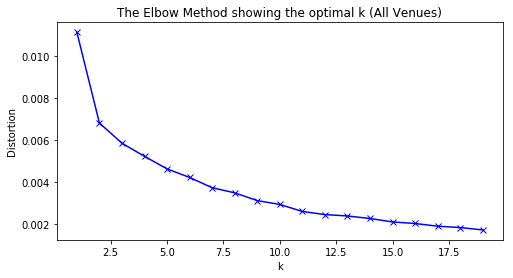

In [36]:
# get labeled venue clusters in city of interest
city = input('Enter city on the recommendation list you are interested in here:')
state = input('Enter the state for the above city here:')
choice_k, venue_labeled = get_local_cluster(city, state)

In [37]:
venue_labeled.head()

,Cluster Labels,Venue,Venue Latitude,Venue Longitude,Venue Category
900,0,North End Park,42.362488,-71.056477,Park
901,0,Faneuil Hall Marketplace,42.359978,-71.056410,Historic Site
902,0,Quincy Market,42.360095,-71.054730,Historic Site
903,0,Sam LaGrassa's,42.356870,-71.059960,Sandwich Place
904,0,Saus Restaurant,42.361076,-71.057054,Belgian Restaurant


In [39]:
# plot clusters on map
df_labeled = pd.read_csv("dream_city_labeled.csv")
w_ind = df_labeled.index[df_merged['City']==city]
w_lat = df_labeled.at[w_ind[0], 'Latitude']
w_lon = df_labeled.at[w_ind[0], 'Longitude']

map_clusters = folium.Map(location=[w_lat, w_lon], zoom_start=13)
map_clusters = plot_map(map_clusters, choice_k, 
                        venue_labeled['Venue Latitude'], venue_labeled['Venue Longitude'], 
                        venue_labeled['Venue Category'], venue_labeled['Cluster Labels'])

map_clusters

In [77]:
venue_onehot = pd.get_dummies(venue_labeled[['Venue Category']], prefix="", prefix_sep="")

# add cluster label column as first column
venue_onehot.insert(loc=0, column='City', value=venue_labeled['Cluster Labels'])
venue_grouped = venue_onehot.groupby('City').mean().reset_index()
venue_grouped.head()

,City,American Restaurant,Aquarium,Asian Restaurant,Bakery,Beer Garden,Belgian Restaurant,Breakfast Spot,Brewery,Café,Chinese Restaurant,Chocolate Shop,Church,Cocktail Bar,Coffee Shop,Cupcake Shop,Dessert Shop,Donut Shop,French Restaurant,Garden,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hockey Arena,Hostel,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lake,Library,Market,Men's Store,Mexican Restaurant,Monument / Landmark,Museum,Neighborhood,New American Restaurant,Opera House,Outdoor Sculpture,Park,Pet Store,Pizza Place,Plaza,Restaurant,River,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Steakhouse,Theater,Trail,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,0,0.000000,0.043478,0.021739,0.021739,0.021739,0.021739,0.000000,0.043478,0.000000,0.000000,0.021739,0.021739,0.021739,0.043478,0.000000,0.000000,0.021739,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.021739,0.065217,0.021739,0.000000,0.021739,0.000000,0.043478,0.000000,0.000000,0.021739,0.043478,0.000000,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.000000,0.086957,0.000000,0.043478,0.000000,0.000000,0.000000,0.043478,0.021739,0.000000,0.065217,0.000000,0.000000,0.021739,0.021739,0.000000,0.000000,0.000000
1,1,0.037037,0.000000,0.000000,0.074074,0.000000,0.000000,0.037037,0.000000,0.018519,0.018519,0.000000,0.000000,0.000000,0.018519,0.018519,0.018519,0.000000,0.037037,0.018519,0.000000,0.018519,0.018519,0.055556,0.000000,0.000000,0.000000,0.018519,0.055556,0.037037,0.037037,0.018519,0.018519,0.000000,0.000000,0.018519,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.018519,0.055556,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.037037,0.018519,0.018519,0.018519,0.037037,0.000000,0.000000,0.018519,0.037037,0.018519


In [78]:
venue_grouped.rename(columns={'Cluster Labels':'City'})
print('Cluster Label for your favorate city is ', recommendation_list[0])
for i in range(0, choice_k):
    if get_custom_label(venue_grouped[venue_grouped['City']==i], 'City')==recommendation_list[0]:
        print('You might also be interested in Cluster ' + str(i) + ' in ' + city)

Cluster Label for your favorate city is  2
You might also be interested in Cluster 0 in Boston
You might also be interested in Cluster 1 in Boston


/Users/zuzuluo/anaconda3/envs/IBMDataScience/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/zuzuluo/anaconda3/envs/IBMDataScience/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
